In [21]:
import index
import yaml
import sys
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from tools import *
sys.path.insert(1, '../../')
from aqua import Reader

In [18]:
namelist = load_namelist()
config   = load_config()
diagname = 'teleconnections'

In [9]:
def set_layout(fig, ax,title=None,xlabel=None,ylabel=None,xlog=False,ylog=False):
    """
    Set the layout of the plot

    Args:
        fig (Figure):           Figure object
        ax (Axes):              Axes object
        title (str,opt):        title of the plot
        xlabel (str,opt):       label of the x axis
        ylabel (str,opt):       label of the y axis
        xlog (bool,opt):        enable or disable x axis log scale, default is False
        ylog (bool,opt):        enable or disable y axis log scale, default is False

    Returns:
        fig (Figure):           Figure object
        ax (Axes):              Axes object
    """
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if xlog:
        ax.set_xscale('symlog')
    if ylog:
        ax.set_yscale('symlog')
    return fig, ax

In [77]:
def index_plot(indx,title=None,xlabel=None,ylabel=None,xlog=False,ylog=False):
    """
    Index plot together with red line at indx=0

    Args:
        indx (DataArray): Index DataArray
    
    Returns:
    """
    # 1. -- Generate the figure --
    fig, ax = plt.subplots(figsize=(12, 8))

    # 2. -- Plot the index --
    colors = ['red' if (value > 0) else 'blue' for value in indx.values]
    #indx_pos = indx.where(indx>=0)
    #indx_neg = indx.where(indx<0)
    #indx_pos.plot(ax=ax, ds='steps', color='red')
    #indx_neg.plot(ax=ax, ds='steps', color='blue')
    colorsnp = np.array(colors)
    indx.plot.scatter(ax=ax,color=colors)#,ds='steps')#,color=colorsnp)
    #indx.plot(ax=ax, ds='steps', color='blue', where=indx<0)
    #indx.plot(ax=ax, ds='steps', color='orange', where=indx>=0)
    ax.hlines(y=0,xmin=min(indx['time']),xmax=max(indx['time']),
              color='black')
    
    # 3. -- Set the layout --
    set_layout(fig, ax, title=title, xlabel=xlabel, ylabel=ylabel, xlog=xlog, ylog=ylog)

    return fig, ax

In [33]:
telecname = 'NAO'
fieldname = namelist[telecname]['field']

In [20]:
infile = config[diagname][telecname]['input']
field = xr.open_mfdataset(infile)[fieldname]

In [22]:
NAO = index.station_based_index(field,namelist,telecname)

/work/users/mnurisso/mambaforge/envs/teleconnections/lib/python3.10/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'test'}, xlabel='time', ylabel='index'>)

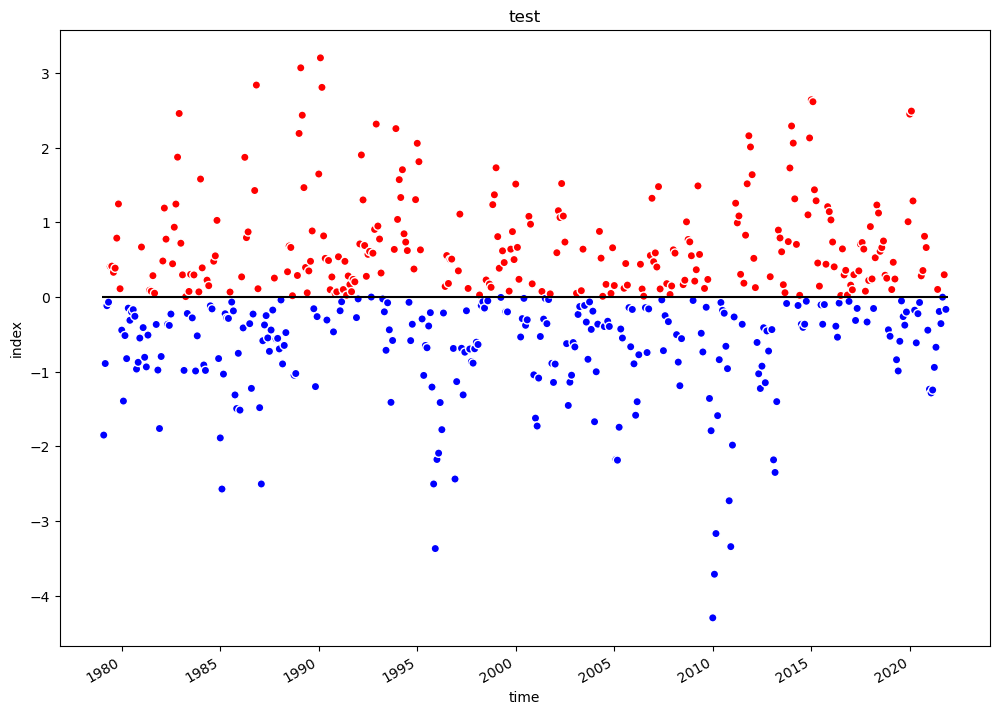

In [78]:
index_plot(NAO,title='test')

In [70]:
type(colors)

list

In [ ]:
colorsnp = np.array(colors)
type(colorsnp)

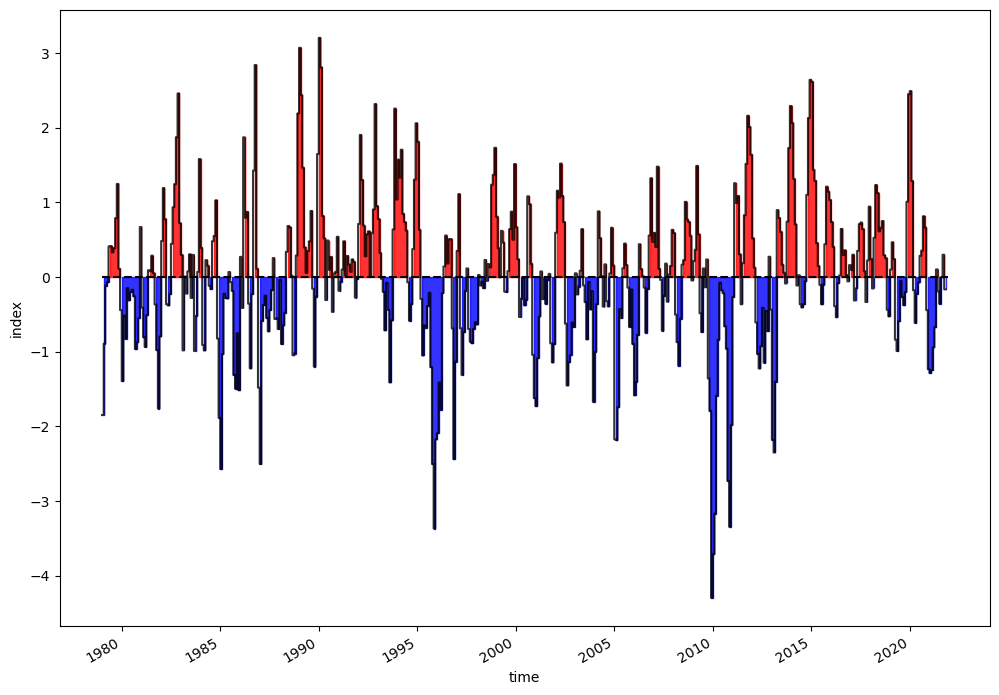

In [98]:
fig, ax = plt.subplots(figsize=(12, 8))

# 2. -- Plot the index --
colors = ['red' if (value > 0) else 'blue' for value in NAO.values]
#indx_pos = indx.where(indx>=0)
#indx_neg = indx.where(indx<0)
#indx_pos.plot(ax=ax, ds='steps', color='red')
#indx_neg.plot(ax=ax, ds='steps', color='blue')

#NAO.plot.scatter(ax=ax,color=colors)
plt.fill_between(NAO.time,NAO.values,where=NAO.values>=0, step="pre", 
                 alpha=0.6,color='red')
plt.fill_between(NAO.time,NAO.values,where=NAO.values<0, step="pre",
                 alpha=0.6,color='blue')
NAO.plot.step(ax=ax,color='black',alpha=0.8)
#indx.plot(ax=ax, ds='steps', color='blue', where=indx<0)
#indx.plot(ax=ax, ds='steps', color='orange', where=indx>=0)
ax.hlines(y=0,xmin=min(NAO['time']),xmax=max(NAO['time']),
            color='black')

# 3. -- Set the layout --
#set_layout(fig, ax, title=title, xlabel=xlabel, ylabel=ylabel, xlog=xlog, ylog=ylog)


In [99]:
NAO

<xarray.DataArray 'index' (time: 516)>
dask.array<truediv, shape=(516,), dtype=float32, chunksize=(3,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [107]:
def reg_plot(indx,field,plot=True,projection_type='PlateCarree',
             title=None,xlabel=None,ylabel=None,xlog=False,ylog=False,
             contour=False,levels=8):
    """
    Evaluate and plot regression map of a teleconnection index 
    and a DataArray field

    Args:
        indx (DataArray):       index DataArray
        field (DataArray):      field DataArray
        projection_type (str):  projection style for cartopy
                                If a wrong one is provided, it will fall back
                                to PlateCarree
        plot (bool):            enable or disable the plot output, true by default
        title (str,opt):        title of the plot
        xlabel (str,opt):       label of the x axis
        ylabel (str,opt):       label of the y axis
        xlog (bool,opt):        enable or disable x axis log scale, default is False
        ylog (bool,opt):        enable or disable y axis log scale, default is False
        contour (bool,opt):     enable or disable contour plot, default is False
        levels (int,opt):       number of contour levels, default is 8
    
    Returns:
        reg (DataArray):        DataArray for regression map
        fig (Figure,opt):       Figure object
        ax (Axes,opt):          Axes object
    """
    # 1. -- List of accepted projection maps --
    projection_types = {
        'PlateCarree': ccrs.PlateCarree(),
        'LambertConformal': ccrs.LambertConformal(),
        'Mercator': ccrs.Mercator()
    }

    # 2. -- Evaluate the regression --
    reg = xr.cov(indx, field, dim="time")/indx.var(dim='time',skipna=True).values
    
    # 3. -- Plot the regression map --
    proj = projection_types.get(projection_type, ccrs.PlateCarree())

    if plot:
        fig, ax = plt.subplots(subplot_kw={'projection': proj},figsize=(8,4))
        
        ax.coastlines()
        if contour:
            reg.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),levels=levels)
        else:
            reg.plot(ax=ax, transform=ccrs.PlateCarree())
        
        set_layout(fig, ax, title=title, xlabel=xlabel, ylabel=ylabel, xlog=xlog, ylog=ylog)
        
        return reg, fig, ax
    else:
        return reg

(<xarray.DataArray (lat: 721, lon: 1440)>
 dask.array<truediv, shape=(721, 1440), dtype=float64, chunksize=(721, 1440), chunktype=numpy.ndarray>
 Coordinates:
   * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
   * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0,
 <Figure size 800x400 with 2 Axes>,
 <GeoAxes: title={'center': 'test'}, xlabel='another test', ylabel='latitude [degrees_north]'>)

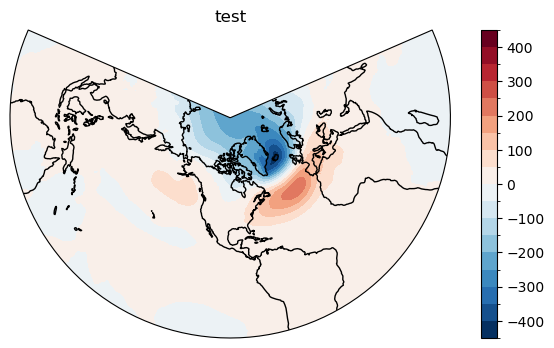

In [115]:
reg_plot(NAO,field,title='test',xlabel='another test',contour=True,levels=20,projection_type = 'LambertConformal')

In [ ]:
def cor_plot(indx,field,projection_type='PlateCarree',plot=True):
    """
    Evaluate and plot correlation map of a teleconnection index 
    and a DataArray field

    Args:
        indx (DataArray):       index DataArray
        field (DataArray):      field DataArray
        projection_type (str):  projection style for cartopy
                                If a wrong one is provided, it will fall back
                                to PlateCarree
        plot (bool):            enable or disable the plot output, true by default
    
    Returns:
        reg (DataArray): DataArray for correlation map
    """
    projection_types = {
        'PlateCarree': ccrs.PlateCarree(),
        'LambertConformal': ccrs.LambertConformal(),
        'Mercator': ccrs.Mercator()
    }

    # 1. -- Evaluate the map --
    cor = xr.corr(indx,field, dim="time")

    proj = projection_types.get(projection_type, ccrs.PlateCarree())

    if plot:
        fig, ax = plt.subplots(subplot_kw={'projection': proj},figsize=(8,4))
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
        ax.coastlines()
        cor.plot(ax=ax)

    return cor